# Notebook for Data import, cleaning, indicator grouping and correlation

## Importing libraries

In [296]:
#Import all libraries that are used in notebooks
import pandas as pd
from scipy import stats
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches as mpatches

## Data

In [48]:
#Importing full 17 goals and combining the data from each excel sheet
FullGoals = pd.read_excel(r'/Users/bkemp/Data Science/Project/Data/Goal1to6.xlsx','Goal1')

for y in range(2,7):
    FullGoals = pd.concat([FullGoals,pd.read_excel(r'/Users/bkemp/Data Science/Project/Data/Goal1to6.xlsx','Goal'+str(y))])
    
for y in range(7,18):
    FullGoals = pd.concat([FullGoals,pd.read_excel(r'/Users/bkemp/Data Science/Project/Data/Goal7to17.xlsx','Goal'+str(y))])

In [86]:
#Importting Sign Data (+ or - which has been assigned and paired with the series code by TOSSIB project)
signData = pd.read_excel(r'/Users/bkemp/Data Science/Project/Data/seriescode_sign_literature.xlsx','seriescode_sign_literature')
signs=signData[['code','sign']] #Extracting only the series code and sign (+/-)
signs.drop_duplicates(inplace=True) #Dropping any duplicate pairs

/Applications/miniconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [275]:
FullGoals

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,Mountain Elevation,Name of international institution,Parliamentary committees,Policy Domains,Policy instruments,Report Ordinal,Sampling Stations,Type of speed,Type of support,Type of waste treatment
0,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,76,Brazil,2001,11.50000,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,76,Brazil,2002,10.20000,2002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,76,Brazil,2003,11.00000,2003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,76,Brazil,2004,9.70000,2004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,76,Brazil,2005,8.60000,2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,76,Brazil,2015,708.02053,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
931,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,76,Brazil,2016,940.31597,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
932,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,76,Brazil,2017,1347.27010,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,76,Brazil,2018,1057.52421,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning Data

In [10]:
#Function to clean and reformat data
def clean(rawData):

    #Drop columns not needed for analysis
    rawData.drop(columns=['Target','SeriesDescription','GeoAreaCode','GeoAreaName','Time_Detail','TimeCoverage','UpperBound','LowerBound','BasePeriod','Source','GeoInfoUrl','FootNote','Nature','Reporting Type','Units'],axis=1,inplace=True)
   
    #Drop columns with all na in the column as has no useful data
    rawData.dropna(axis=1,how='all',inplace=True)
    
    #Apply signs (+/-)
    for j in range(0,len(signs)):
        code=signs.iloc[j][0] #Set series code
        sig=signs.iloc[j][1] #Set associated sign
        rawData.loc[rawData['SeriesCode']==code,'Value']=rawData.loc[rawData['SeriesCode']==code,'Value']*sig #Select column with series code we have and then apply sign to that column (looped for whole list of signs)
        
    #Extract columns that data is split up by (age, sex etc.)
    disagg=rawData.columns[4:].tolist() #Taking data other than first 4 columns which have Goal, Indicator, SeriesCode and TimePeriod
    col=['Goal','Indicator','SeriesCode']
    for j in range(0,len(disagg)):
        if disagg[j] != 'Value': #Looping through for each data series to get all disaggregators, leaving out column with data values
            col.append(disagg[j])
        
    #Pivot data using index as the time and values as data values with the columns the ones we extracted
    Data=rawData.pivot(index='TimePeriod',columns=col,values='Value')
    
    #Drop data with less than 3 values, as the pradhan study didnt consider any data that had less than 3 entries
    Data.dropna(axis=1,thresh=3,inplace=True)
    
    #Set data for New Dataframe for first column only
    Years=Data.index.values #Index of the years
    col1=Data.iloc[:,0] #Get first column only
    col1val=col1.values #Get values from that column
    col1name=col1.name #Get name of that column (Goal, Indicator, SeriesCode and disaggregators)
    col1code=col1name[2]+'--' #Extract SeriesCode and add '--' for later naming purposes

    #For first column only loop to take disaggregators out and add them to the end of the SeriesCode only if they are a string (i.e. not NaN)
    for n in range(1,len(col1name)-2):
        if type(col1name[n+2]) == str:
            col1code=col1code+col1name[n+2]+'_'
     
    #New dataframe set with only first column and (Goal, Indicator, New SeriesCode)
    cleanData=pd.DataFrame(col1val,index=Years,columns=[[col1name[0]],[col1name[1]],[col1code]])

    #Same loop as before for new SeriesCode but for all columns in the data and then adding columns to dataframe
    for k in range(1,len(Data.columns)-1):
        colname=Data.iloc[:,k].name
        colcode=colname[2]+'--'
        for n in range(1,len(colname)-2):
            if type(colname[n+2]) == str:
                colcode=colcode+colname[n+2]+'_'
        cleanData[colname[0],colname[1],colcode]=Data.iloc[:,k].values
        
        
    return cleanData

In [81]:
#Run Function
clnData=clean(FullGoals)

/var/folders/5h/nl7cgmvx6cv0_q4zj9wkhhg00000gn/T/ipykernel_15092/794070180.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  cleanData[colname[0],colname[1],colcode]=Data.iloc[:,k].values


In [82]:
#Save DataFrame As pickle for storage purposes and so we don't have to rerun code everytime
clnData.to_pickle('CleanDataAllGoals')

In [49]:
#Loading pickle of clean data
CleanDataAllGoals=pd.read_pickle('CleanDataAllGoals')

In [276]:
#Visualising clean data
CleanDataAllGoals

1                                                       \
             1.1.1                                                       
     SI_POV_DAY1-- SI_POV_EMP1--25+_BOTHSEX_ SI_POV_EMP1--15+_BOTHSEX_   
2000           NaN                      -8.1                      -8.1   
2001         -11.5                      -7.5                      -7.5   
2002         -10.2                      -6.9                      -6.9   
2003         -11.0                      -7.4                      -7.4   
2004          -9.7                      -5.4                      -5.8   
2005          -8.6                      -4.9                      -5.2   
2006          -7.2                      -3.9                      -4.2   
2007          -6.7                      -3.5                      -3.7   
2008          -5.5                      -2.8                      -2.9   
2009          -5.4                      -2.6                      -2.7   
2010           NaN                      -2.1                      -2.3   
2011          -4.7                      -2.0                      -2.1   
2012          -3.7                      -1.4                      -1.5   
2013          -3.1                      -0.8                      -0.9   
2014          -2.7                      -0.7                      -0.8   
2015          -3.2                      -0.9                      -0.9   
2016          -3.9                      -1.3                      -1.3   
2017          -4.4                      -1.8                      -1.8   
2018          -4.4                      -1.8                      -1.8   
2019          -4.6                       NaN                       NaN   
2020           NaN                       NaN                       NaN   

                                                        \
                                                         
     SI_POV_EMP1--15+_FEMALE_ SI_POV_EMP1--25+_FEMALE_   
2000                     -7.9                     -7.9   
2001                     -7.4                     -7.5   
2002                     -6.6                     -6.7   
2003                     -7.3                     -7.3   
2004                     -5.5                     -5.2   
2005                     -5.1                     -4.8   
2006                     -4.0                     -3.8   
2007                     -3.7                     -3.5   
2008                     -2.9                     -2.8   
2009                     -2.6                     -2.5   
2010                     -2.1                     -2.1   
2011                     -1.9                     -1.9   
2012                     -1.4                     -1.3   
2013                     -0.8                     -0.8   
2014                     -0.7                     -0.7   
2015                     -0.8                     -0.8   
2016                     -1.3                     -1.3   
2017                     -1.8                     -1.8   
2018                     -1.8                     -1.9   
2019                      NaN                      NaN   
2020                      NaN                      NaN   

                                                                             \
                                                                              
     SI_POV_EMP1--15-24_MALE_ SI_POV_EMP1--15+_MALE_ SI_POV_EMP1--25+_MALE_   
2000                     -8.7                   -8.3                   -8.2   
2001                     -7.7                   -7.5                   -7.4   
2002                     -7.3                   -7.0                   -7.0   
2003                     -7.5                   -7.4                   -7.4   
2004                     -7.6                   -6.0                   -5.6   
2005                     -6.6                   -5.3                   -4.9   
2006                     -5.8                   -4.3                   -3.9   
2007                     -4.8                   -3.8    

## Correlation

In [51]:
#Performing spearming correlation on dataframe (every column with every column), with a minimum number of data pairs of 10 as determined in analysis
corrmat=CleanDataAllGoals.corr(method="spearman",min_periods=10)

In [52]:
#Dropping columns which did not have enough data (10 data points) as all their values are now nan
corrmat.dropna(how='all',axis=1,inplace=True)
corrmat.dropna(how='all',axis=0,inplace=True)

In [54]:
#Saving correlation matrix to pickle format
corrmat.to_pickle('CorrelationAllGoals')

In [55]:
#Loading pickle for correlation
CorrelationAllGoals=pd.read_pickle('CorrelationAllGoals')

In [56]:
#Visualising Correlation Matrix
CorrelationAllGoals

1                             \
                                            1.1.1                             
                                    SI_POV_DAY1-- SI_POV_EMP1--25+_BOTHSEX_   
1  1.1.1  SI_POV_DAY1--                  1.000000                  0.997546   
          SI_POV_EMP1--25+_BOTHSEX_      0.997546                  1.000000   
          SI_POV_EMP1--15+_BOTHSEX_      0.996931                  0.999561   
          SI_POV_EMP1--15+_FEMALE_       0.996931                  0.999561   
          SI_POV_EMP1--25+_FEMALE_       0.996929                  0.997804   
...                                           ...                       ...   
17 17.3.2 BX_TRF_PWKR--                 -0.905524                 -0.836332   
   17.4.1 DT_TDS_DECT--                 -0.735158                 -0.739798   
   17.6.1 IT_NET_BBND--ANYS_             0.840475                  0.920579   
          IT_NET_BBNDN--ANYS_            0.840475                  0.920579   
   17.8.1 IT_USE_ii99--                  0.840475                  0.920579   

                                                               \
                                                                
                                    SI_POV_EMP1--15+_BOTHSEX_   
1  1.1.1  SI_POV_DAY1--                              0.996931   
          SI_POV_EMP1--25+_BOTHSEX_                  0.999561   
          SI_POV_EMP1--15+_BOTHSEX_                  1.000000   
          SI_POV_EMP1--15+_FEMALE_                   1.000000   
          SI_POV_EMP1--25+_FEMALE_                   0.998242   
...                                                       ...   
17 17.3.2 BX_TRF_PWKR--                             -0.830553   
   17.4.1 DT_TDS_DECT--                             -0.734855   
   17.6.1 IT_NET_BBND--ANYS_                         0.922740   
          IT_NET_BBNDN--ANYS_                        0.922740   
   17.8.1 IT_USE_ii99--                              0.922740   

                                                              \
                                                               
                                    SI_POV_EMP1--15+_FEMALE_   
1  1.1.1  SI_POV_DAY1--                             0.996931   
          SI_POV_EMP1--25+_BOTHSEX_                 0.999561   
          SI_POV_EMP1--15+_BOTHSEX_                 1.000000   
          SI_POV_EMP1--15+_FEMALE_                  1.000000   
          SI_POV_EMP1--25+_FEMALE_                  0.998242   
...                                                      ...   
17 17.3.2 BX_TRF_PWKR--                            -0.830553   
   17.4.1 DT_TDS_DECT--                            -0.734855   
   17.6.1 IT_NET_BBND--ANYS_                        0.922740   
          IT_NET_BBNDN--ANYS_                       0.922740   
   17.8.1 IT_USE_ii99--                             0.922740   

                                                              \
                                                               
                                    SI_POV_EMP1--25+_FEMALE_   
1  1.1.1  SI_POV_DAY1--                             0.996929   
          SI_POV_EMP1--25+_BOTHSEX_                 0.997804   
          SI_POV_EMP1--15+_BOTHSEX_                 0.998242   
          SI_POV_EMP1--15+_FEMALE_                  0.998242   
          SI_POV_EMP1--25+_FEMALE_                  1.000000   
...                                                      ...   
17 17.3.2 BX_TRF_PWKR--                            -0.840580   
   17.4.1 DT_TDS_DECT--                            -0.748354   
   17.6.1 IT_NET_BBND--ANYS_                        0.912605   
          IT_NET_BBNDN--ANYS_                       0.912605   
   17.8.1 IT_USE_ii99--                             0.912605   

                                                              \
                                                               
                                    SI_POV_EMP1--15-24_MALE_   
1  1.1.1  SI_POV_DAY1--                    

## Grouping Indicators

In [108]:
#Creating a list of indicators by goal they are in
IndicatorList = []

#for 1 to 17, y = goal, takes SeriesCode for all Goal 1 and places in list, Goal 2 etc
for y in range(1,18):
    IndicatorList.append(CleanDataAllGoals.loc[:,y].columns.get_level_values(1).values)

In [115]:
#Saving indicator list
with open(r'/Users/bkemp/Data Science/Project/IndicatorList.ob','wb') as fp:
        pickle.dump(IndicatorList,fp)

In [4]:
#Importing Indicator list
with open(r'/Users/bkemp/Data Science/Project/IndicatorList.ob','rb') as fp:
        IndicatorList= pickle.load(fp)

In [5]:
#Visualising Indicator list which is a list of lists (list 1 is goal 1 seriescodes, list 2 is goal 2 etc.)
IndicatorList

[array(['SI_POV_DAY1--', 'SI_POV_EMP1--25+_BOTHSEX_',
        'SI_POV_EMP1--15+_BOTHSEX_', 'SI_POV_EMP1--15+_FEMALE_',
        'SI_POV_EMP1--25+_FEMALE_', 'SI_POV_EMP1--15-24_MALE_',
        'SI_POV_EMP1--15+_MALE_', 'SI_POV_EMP1--25+_MALE_',
        'SI_POV_EMP1--15-24_BOTHSEX_', 'SI_POV_EMP1--15-24_FEMALE_',
        'SI_COV_DISAB--BOTHSEX_', 'SI_COV_LMKT--Q1_', 'SI_COV_LMKT--_T_',
        'SI_COV_PENSN--BOTHSEX_', 'SI_COV_POOR--BOTHSEX_',
        'SI_COV_SOCAST--_T_', 'SI_COV_SOCAST--Q1_', 'SI_COV_SOCINS--Q1_',
        'SI_COV_SOCINS--_T_', 'SI_COV_UEMP--BOTHSEX_',
        'SP_ACS_BSRVH2O--URBAN_', 'SP_ACS_BSRVH2O--RURAL_',
        'SP_ACS_BSRVH2O--ALLAREA_', 'SP_ACS_BSRVSAN--RURAL_',
        'SP_ACS_BSRVSAN--ALLAREA_', 'SP_ACS_BSRVSAN--URBAN_',
        'VC_DSR_AFFCT--', 'VC_DSR_DAFF--', 'VC_DSR_IJILN--',
        'VC_DSR_MISS--', 'VC_DSR_MMHN--', 'VC_DSR_MORT--', 'VC_DSR_MTMP--',
        'VC_DSR_PDAN--', 'VC_DSR_PDYN--', 'VC_DSR_AGLH--', 'VC_DSR_CILN--',
        'VC_DSR_DDPA--', 'VC_

## Info about indicator

In [5]:
#A quick method to get data about the indicators by goal
indData=FullGoals.copy()

In [6]:
#Dropping all columns that aren't needed, NaN's and duplicates
indData.drop(columns=['TimePeriod','Value','GeoAreaCode','GeoAreaName','Time_Detail','TimeCoverage','UpperBound','LowerBound','BasePeriod','Source','GeoInfoUrl','FootNote','Nature','Reporting Type'],axis=1,inplace=True)
indData.dropna(axis=1,how='all',inplace=True)
indData.drop_duplicates(inplace=True)

In [9]:
#Saving this raw data
indData.to_pickle('RawDataAllGoals')

In [4]:
#Loading raw data
indData=pd.read_pickle('RawDataAllGoals')

In [280]:
#Search for Indicators from specific goal, run and input a single number (1 to 17) and it will search the dataframe and giving only results from that goal
GoalSearch=indData.loc[indData['Goal']==int(input('Enter Goal: '))].dropna(axis=1,how='all',inplace=False)
GoalSearch

Enter Goal: 6


,Goal,Target,Indicator,SeriesCode,SeriesDescription,Activity,Age,Deviation Level,Education level,Freq,Level/Status,Location,Observation Status,Quantile,Sex,Type of occupation,Type of product,Units
0,6,6.1,6.1.1,SH_H2O_SAFE,Proportion of population using safely managed ...,NaN,NaN,NaN,NaN,NaN,NaN,ALLAREA,NaN,NaN,NaN,NaN,NaN,PERCENT
1,6,6.1,6.1.1,SH_H2O_SAFE,Proportion of population using safely managed ...,NaN,NaN,NaN,NaN,NaN,NaN,RURAL,NaN,NaN,NaN,NaN,NaN,PERCENT
2,6,6.1,6.1.1,SH_H2O_SAFE,Proportion of population using safely managed ...,NaN,NaN,NaN,NaN,NaN,NaN,URBAN,NaN,NaN,NaN,NaN,NaN,PERCENT
63,6,6.2,6.2.1,SH_SAN_DEFECT,Proportion of population practicing open defec...,NaN,NaN,NaN,NaN,NaN,NaN,RURAL,NaN,NaN,NaN,NaN,NaN,PERCENT
64,6,6.2,6.2.1,SH_SAN_DEFECT,Proportion of population practicing open defec...,NaN,NaN,NaN,NaN,NaN,NaN,ALLAREA,NaN,NaN,NaN,NaN,NaN,PERCENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,6,6.a,6.a.1,DC_TOF_WASHL,Total official development assistance (gross d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CON_USD
595,6,6.b,6.b.1,ER_H2O_PRDU,Countries with procedures in law or policy for...,NaN,NaN,NaN,NaN,NaN,NaN,RURAL,NaN,NaN,NaN,NaN,NaN,NUMBER
599,6,6.b,6.b.1,ER_H2O_RURP,Countries with users/communities participating...,NaN,NaN,NaN,NaN,NaN,NaN,RURAL,NaN,NaN,NaN,NaN,NaN,NUMBER
603,6,6.b,6.b.1,ER_WAT_PART,Countries with users/communities participating...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NUMBER


# Search for indicator

In [323]:
#Search for specific indicator using base series code, run and enter series code without disaggregators added as it appears in the original data
#Will print out Goal, target, indicator, seriescode, seriesdescription and any disaggregators present as well as units
indSearch=indData.loc[indData['SeriesCode']==input('Enter Series Code: ')].dropna(axis=1,how='all',inplace=False)
indSearch

Enter Series Code: GR_G14_GDP


,Goal,Target,Indicator,SeriesCode,SeriesDescription,Observation Status,Units
0,17,17.1,17.1.1,GR_G14_GDP,Total government revenue (budgetary central go...,A,PERCENT


In [324]:
#Get Full Description of series description if cut off
indSearch.loc[:,'SeriesDescription'].values

array(['Total government revenue (budgetary central government) as a proportion of GDP (%)'],
      dtype=object)

## Comparing two indicators

In [282]:
#Comparing two indicators from clean dataframe
GoalSearch=CleanDataAllGoals.copy()
GoalSearch.columns=GoalSearch.columns.get_level_values(2) #Setting columns to only new seriescode

In [293]:
#Change series code in brackets to two indicators you want to compare and will produce those two data columns only
GoalSearch.loc[:,[('SI_POV_DAY1--'),('SP_ACS_BSRVH2O--RURAL_')]]

,SI_POV_DAY1--,SP_ACS_BSRVH2O--RURAL_
2000,NaN,73.0
2001,-11.5,74.0
2002,-10.2,75.0
2003,-11.0,76.0
2004,-9.7,77.0
2005,-8.6,78.0
2006,-7.2,79.0
2007,-6.7,81.0
2008,-5.5,82.0
2009,-5.4,83.0


## Check sign (+/-) by series code

In [125]:
#Check if there is a sign for the series code
signSeriesCode=input('Series Code:') #Run and Input original series code
signs.loc[signs['code']==str(signSeriesCode)] #Gives seriescode and sign if there is a sign (+/-) in the sign data

Series Code:EN_LKRV_PWAP


,code,sign
77,EN_LKRV_PWAP,1


### Plotting two timeseries

In [291]:
plotData=GoalSearch.loc[:,[('SI_POV_DAY1--'),('SP_ACS_BSRVH2O--RURAL_')]] #Two columns of data we want to plot
ind1Data=plotData.iloc[:,0].values #Getting values of first column
ind2Data=plotData.iloc[:,1].values #Getting values of second column
indexData=plotData.index

In [312]:
#Setting colour and labels for Goal and indicator
ind111 = mpatches.Patch(color='red', label='Goal 1, Indicator 1.1.1')
ind141 = mpatches.Patch(color='red', label='Goal 1, Indicator 1.4.1')

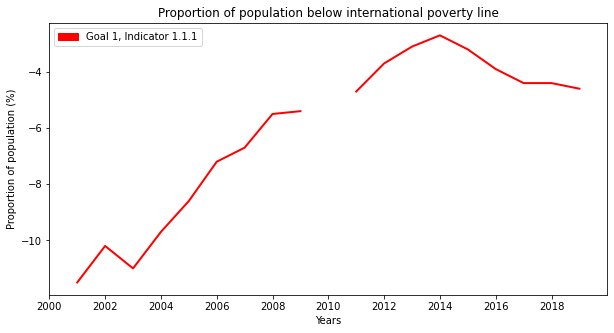

In [313]:
#First column
plt.figure(figsize=(10,5)) #Set figure size
plt.plot(indexData,ind1Data,color='red',linewidth=2) #Plot time-series
plt.title('Proportion of population below international poverty line')
plt.xlabel('Years')
plt.ylabel('Proportion of population (%)')
plt.legend(loc='upper left',handles=[ind111]) #Plot legend
plt.xlim([2000,2020])
plt.xticks(np.arange(2000,2020, 2))
plt.show()

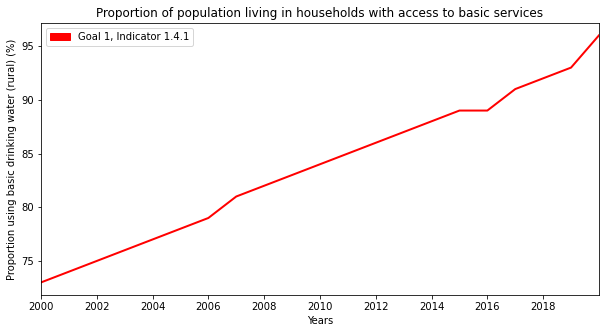

In [314]:
#Second column
plt.figure(figsize=(10,5)) #Set figure size
plt.plot(indexData,ind2Data,color='red',linewidth=2) #Plot time-series
plt.title('Proportion of population living in households with access to basic services')
plt.xlabel('Years')
plt.ylabel('Proportion using basic drinking water (rural) (%)')
plt.legend(loc='upper left',handles=[ind141])#Plot legend
plt.xlim([2000,2020])
plt.xticks(np.arange(2000,2020, 2))
plt.show()